In [1]:
import torch
from datasets.citispace import create_cityscapes_dataloaders
import matplotlib.pyplot as plt
import numpy as np
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from train import train_one_epoch
import json

In [2]:
# Load the data
base_path = 'data'  # base path of where the cityscapes dataset is stored
train_loader, val_loader, test_loader = create_cityscapes_dataloaders(
    base_path=base_path,
    batch_size=8,
    num_workers=4
)

Citispace data is previously downloaded...!


In [3]:
# Get a batch of data and print sizes
images, masks = next(iter(train_loader))
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

Image size: torch.Size([8, 3, 256, 256])
Mask size: torch.Size([8, 256, 256])


In [4]:
# Get Cityscapes classes from the dataset
CITYSCAPES_CLASSES = {
    0: 'background',
    1: 'road',
    2: 'sidewalk',
    3: 'building',
    4: 'wall',
    5: 'fence',
    6: 'pole',
    7: 'traffic light',
    8: 'traffic sign',
    9: 'vegetation',
    10: 'terrain',
    11: 'sky',
    12: 'person',
    13: 'rider',
    14: 'car',
    15: 'truck',
    16: 'bus',
    17: 'train',
    18: 'motorcycle',
    19: 'bicycle',
    255: 'ignore'  # Special ignore class
}


# Create a color palette for visualization
COLOR_PALETTE = {
    0: (0, 0, 0),        # background: black
    1: (128, 64, 128),   # road: purple
    2: (244, 35, 232),   # sidewalk: pink
    3: (70, 70, 70),     # building: dark gray
    4: (102, 102, 156),  # wall: dark blue-gray
    5: (190, 153, 153),  # fence: light pink
    6: (153, 153, 153),  # pole: gray
    7: (250, 170, 30),   # traffic light: orange
    8: (220, 220, 0),    # traffic sign: yellow
    9: (107, 142, 35),   # vegetation: green
    10: (152, 251, 152), # terrain: light green
    11: (70, 130, 180),  # sky: blue
    12: (220, 20, 60),   # person: red
    13: (255, 0, 0),     # rider: bright red
    14: (0, 0, 142),     # car: dark blue
    15: (0, 0, 70),      # truck: darker blue
    16: (0, 60, 100),    # bus: medium blue
    17: (0, 80, 100),    # train: blue
    18: (0, 0, 230),     # motorcycle: bright blue
    19: (119, 11, 32),   # bicycle: dark red
    255: (0, 0, 0)       # ignore: black
}

# Function to plot colormap legend
def plot_colormap_legend():
    num_cols = 5
    num_rows = (len(CITYSCAPES_CLASSES) + num_cols - 1) // num_cols
    fig, ax = plt.subplots(figsize=(15, num_rows * 2))

    for idx, (class_id, class_name) in enumerate(CITYSCAPES_CLASSES.items()):
        if class_id == 255:  # Skip ignore class in visualization
            continue
        row = idx // num_cols
        col = idx % num_cols
        color = [x/255.0 for x in COLOR_PALETTE[class_id]]
        ax.add_patch(plt.Rectangle((col, -row), 1, 1, facecolor=color))
        ax.text(col + 0.5, -row + 0.5, class_name,
                ha='center', va='center', rotation=45, fontsize=10, color='white' if sum(color) < 1.5 else 'black')

    ax.set_xlim(0, num_cols)
    ax.set_ylim(-num_rows, 1)
    ax.axis('off')
    plt.title('Cityscapes Classes Color Map')
    plt.tight_layout()
    plt.show()

In [5]:
def plot_predictions(images, masks, predictions=None, n_samples=4):
    n_rows = 2 if predictions is None else 3
    fig, axes = plt.subplots(n_rows, n_samples, figsize=(15, 5*n_rows))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
        for class_id, color in COLOR_PALETTE.items():
            mask_indices = (mask == class_id)
            if class_id != 255:  # Skip ignore label
                colored_mask[mask_indices] = [x/255.0 for x in color]  # Normalize color values
        axes[1, i].imshow(colored_mask)
        axes[1, i].axis('off')
        axes[1, i].set_title('Ground Truth')

        # Plot prediction if available
        if predictions is not None:
            pred = torch.argmax(predictions[i], dim=0).cpu().numpy()
            colored_pred = np.zeros((*pred.shape, 3), dtype=np.float32)  # Changed to float32
            for class_id, color in COLOR_PALETTE.items():
                pred_indices = (pred == class_id)
                if class_id != 255:  # Skip ignore label
                    colored_pred[pred_indices] = [x/255.0 for x in color]  # Normalize color values
            axes[2, i].imshow(colored_pred)
            axes[2, i].axis('off')
            axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

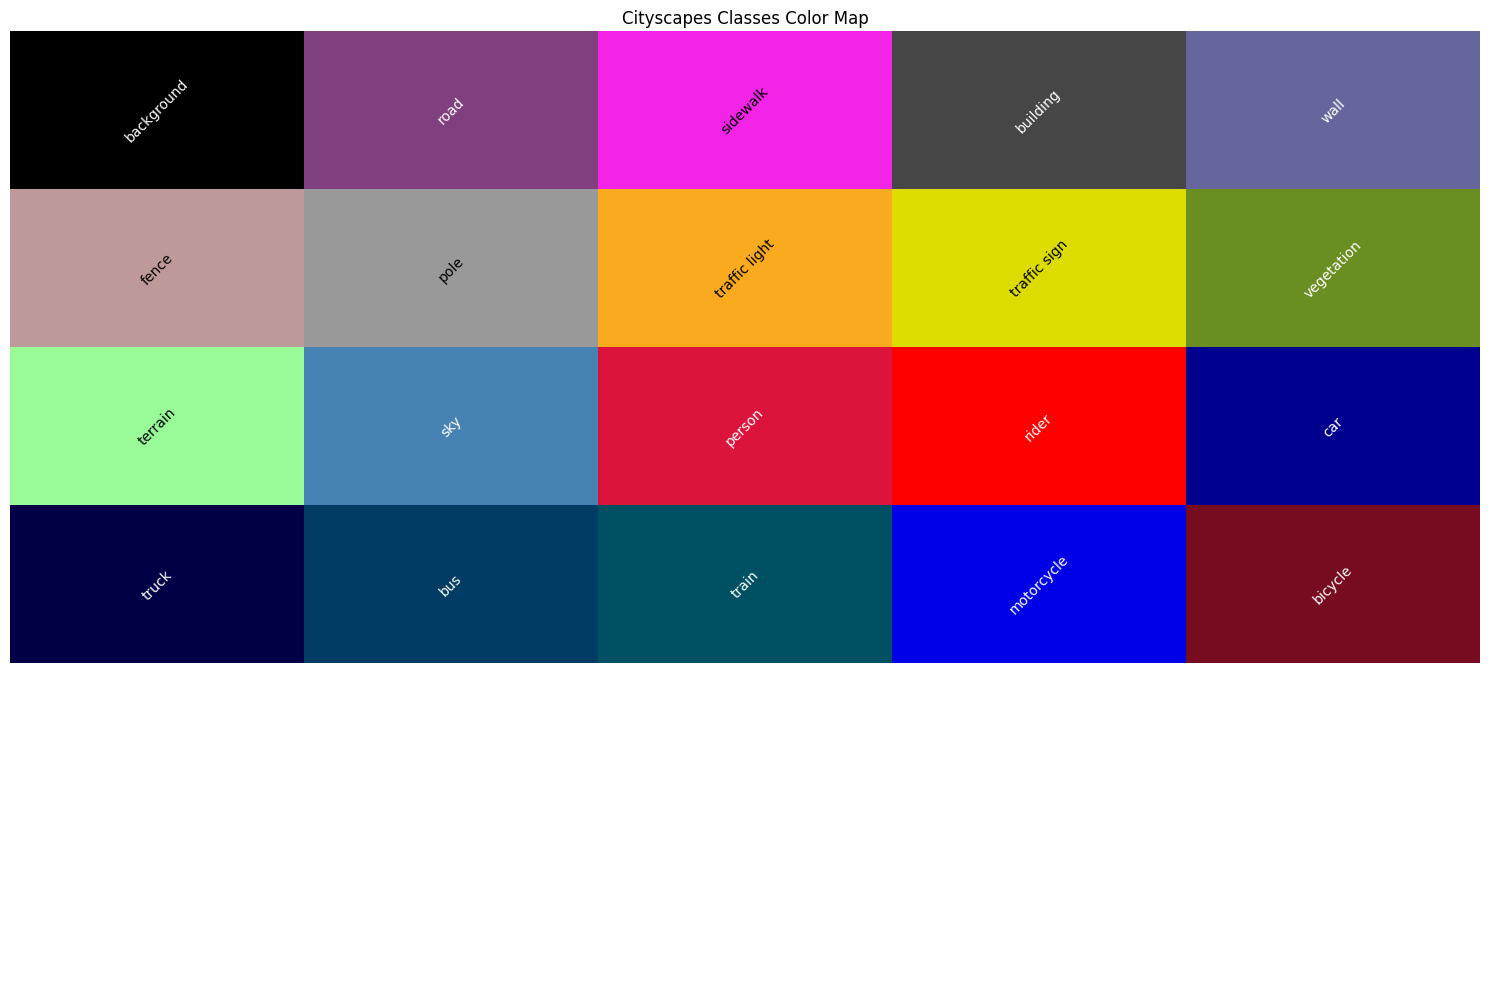

In [8]:
# Plot the colormap legend and some sample images
plot_colormap_legend()

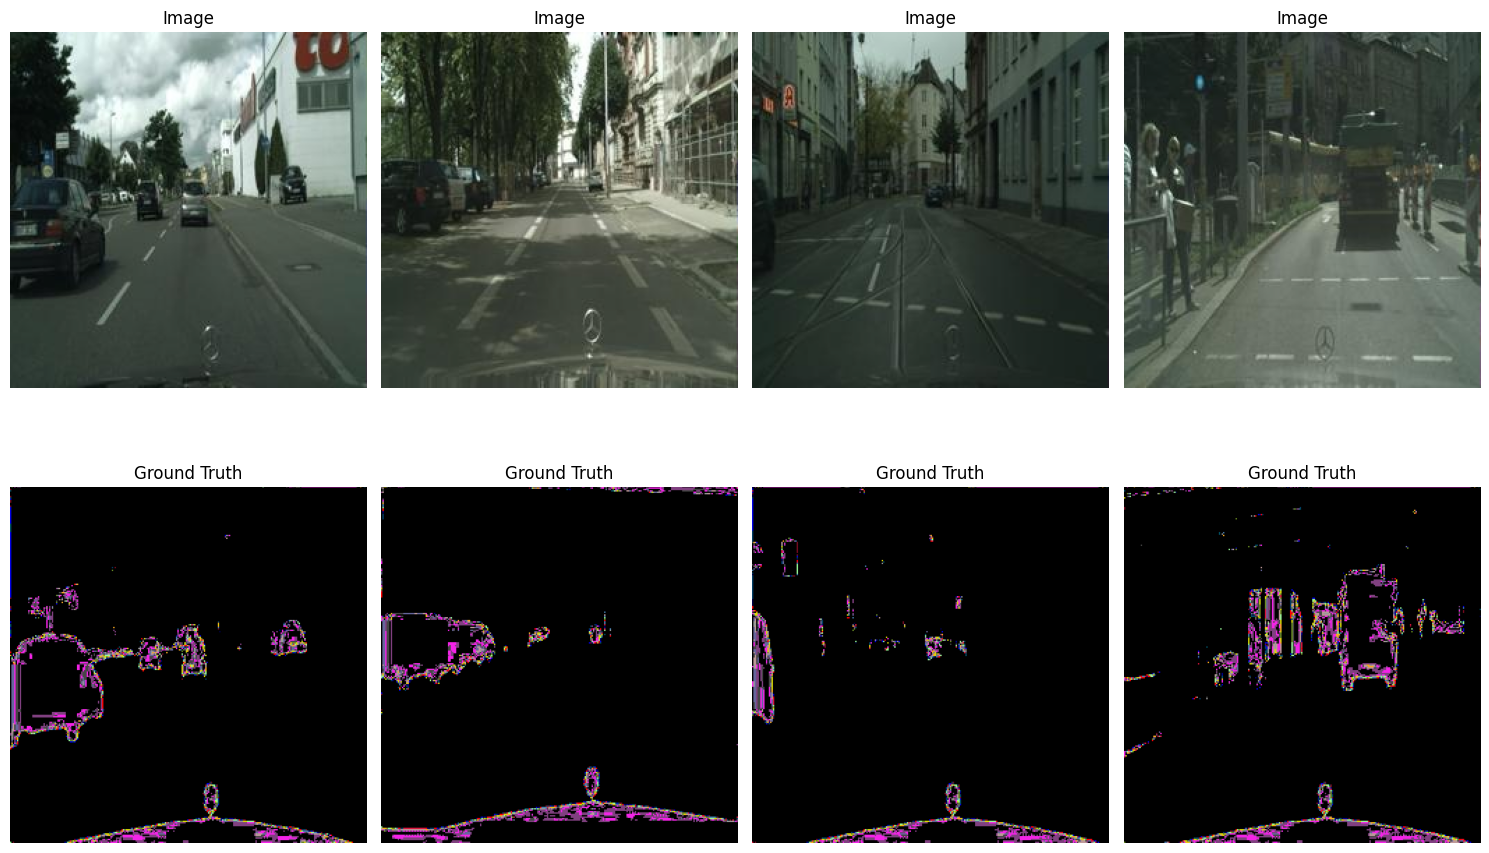

In [6]:
plot_predictions(images, masks, n_samples=4)

In [7]:
from torchmetrics import Dice, JaccardIndex, Precision, Recall, F1Score, ConfusionMatrix


def calculate_metrics(outputs, targets, n_classes):
    """
    Calculate evaluation metrics for multiclass image segmentation.
    Args:
        outputs (torch.Tensor): Model predictions (B, C, H, W)
        targets (torch.Tensor): Ground truth labels (B, H, W)
        n_classes (int): Number of classes (excluding ignore class)
    Returns:
        dict: Dictionary containing various metrics
    """
    # Move tensors to CPU for metric calculation
    outputs = outputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    targets = targets.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Get predictions
    preds = torch.argmax(outputs, dim=1)

    # Create mask for valid pixels (not ignore class)
    valid_mask = targets != 255

    # Filter out ignore class pixels
    valid_preds = preds[valid_mask]
    valid_targets = targets[valid_mask]

    # Initialize metrics
    dice = Dice(
        num_classes=n_classes,
        average='macro'
    )

    iou = JaccardIndex(
        task="multiclass",
        num_classes=n_classes,
        average='macro'
    )

    precision = Precision(
        task="multiclass",
        num_classes=n_classes,
        average='macro'
    )

    recall = Recall(
        task="multiclass",
        num_classes=n_classes,
        average='macro'
    )

    f1 = F1Score(
        task="multiclass",
        num_classes=n_classes,
        average='macro'
    )

    confmat = ConfusionMatrix(
        task="multiclass",
        num_classes=n_classes
    )

    # Calculate metrics only on valid pixels
    metrics = {
        'dice': dice(valid_preds, valid_targets).item(),
        'iou': iou(valid_preds, valid_targets).item(),
        'precision': precision(valid_preds, valid_targets).item(),
        'recall': recall(valid_preds, valid_targets).item(),
        'f1_score': f1(valid_preds, valid_targets).item(),
        'confusion_matrix': confmat(valid_preds, valid_targets).cpu().numpy()
    }

    # Calculate per-class metrics
    per_class_metrics = {}
    for cls in range(n_classes):
        # Create binary masks for current class (only for valid pixels)
        cls_preds = (valid_preds == cls)
        cls_targets = (valid_targets == cls)

        # Skip if class not present in ground truth
        if not cls_targets.any():
            continue

        # Calculate binary metrics for this class
        cls_dice = Dice(average='micro')(cls_preds, cls_targets).item()
        cls_iou = JaccardIndex(task="binary")(cls_preds, cls_targets).item()

        per_class_metrics[f'class_{cls}_dice'] = cls_dice
        per_class_metrics[f'class_{cls}_iou'] = cls_iou

    metrics.update(per_class_metrics)
    return metrics

import tqdm
def validate(model, loader, criterion, device, n_classes):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []
    with tqdm.tqdm(loader) as pbar:
        with torch.no_grad():
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                total_loss += loss.item()

                # Store outputs and targets for later metric calculation
                all_outputs.append(outputs.cpu())
                all_targets.append(masks.cpu())

    # Concatenate all batches
    outputs = torch.cat(all_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Calculate metrics once for the entire epoch
    metrics = calculate_metrics(outputs, targets, n_classes)

    return total_loss / len(loader), metrics

In [8]:
from early_stopping import EarlyStopping
# Training setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 20
model = UNet(n_channels=3, n_classes=num_classes, dropout_rate=0.3, use_batchnorm=True).to(device)
criterion = CrossEntropyLoss(ignore_index=255)  # Ignore index for Cityscapes
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'learning_rates': []
}

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, num_classes)
    print("Running validation")
    # Validation phase
    val_loss, val_metrics = validate(model, val_loader, criterion, device, num_classes)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'cityscapes_ce_model.pth')
with open('cityscapes_ce_training_history.json', 'w') as f:
    json.dump(history, f)


Epoch 1/2


  0%|          | 0/4 [00:01<?, ?it/s]


ValueError: The highest label in `target` should be smaller than `num_classes`.

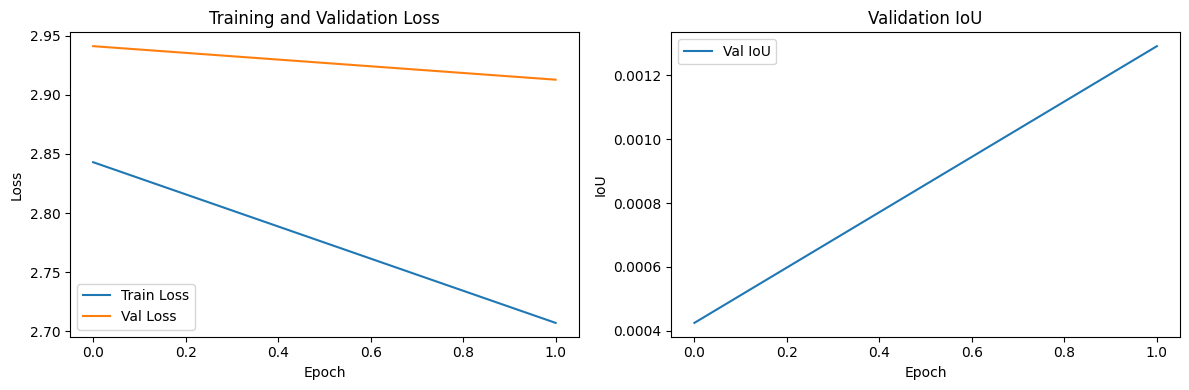

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Validation IoU')

plt.tight_layout()
plt.show()

In [16]:
# Load the best model and run predictions
import torch
from unet import UNet
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        colored_mask = np.zeros((*mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            if class_id != 255:  # Skip ignore label
                colored_mask[mask == class_id] = [x/255 for x in color]
        axes[i, 1].imshow(colored_mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        colored_pred = np.zeros((*pred_mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            if class_id != 255:  # Skip ignore label
                colored_pred[pred_mask == class_id] = [x/255 for x in color]
        axes[i, 2].imshow(colored_pred)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

/tmp/ipykernel_52161/1798618319.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('cityscapes_ce_model.pth'))


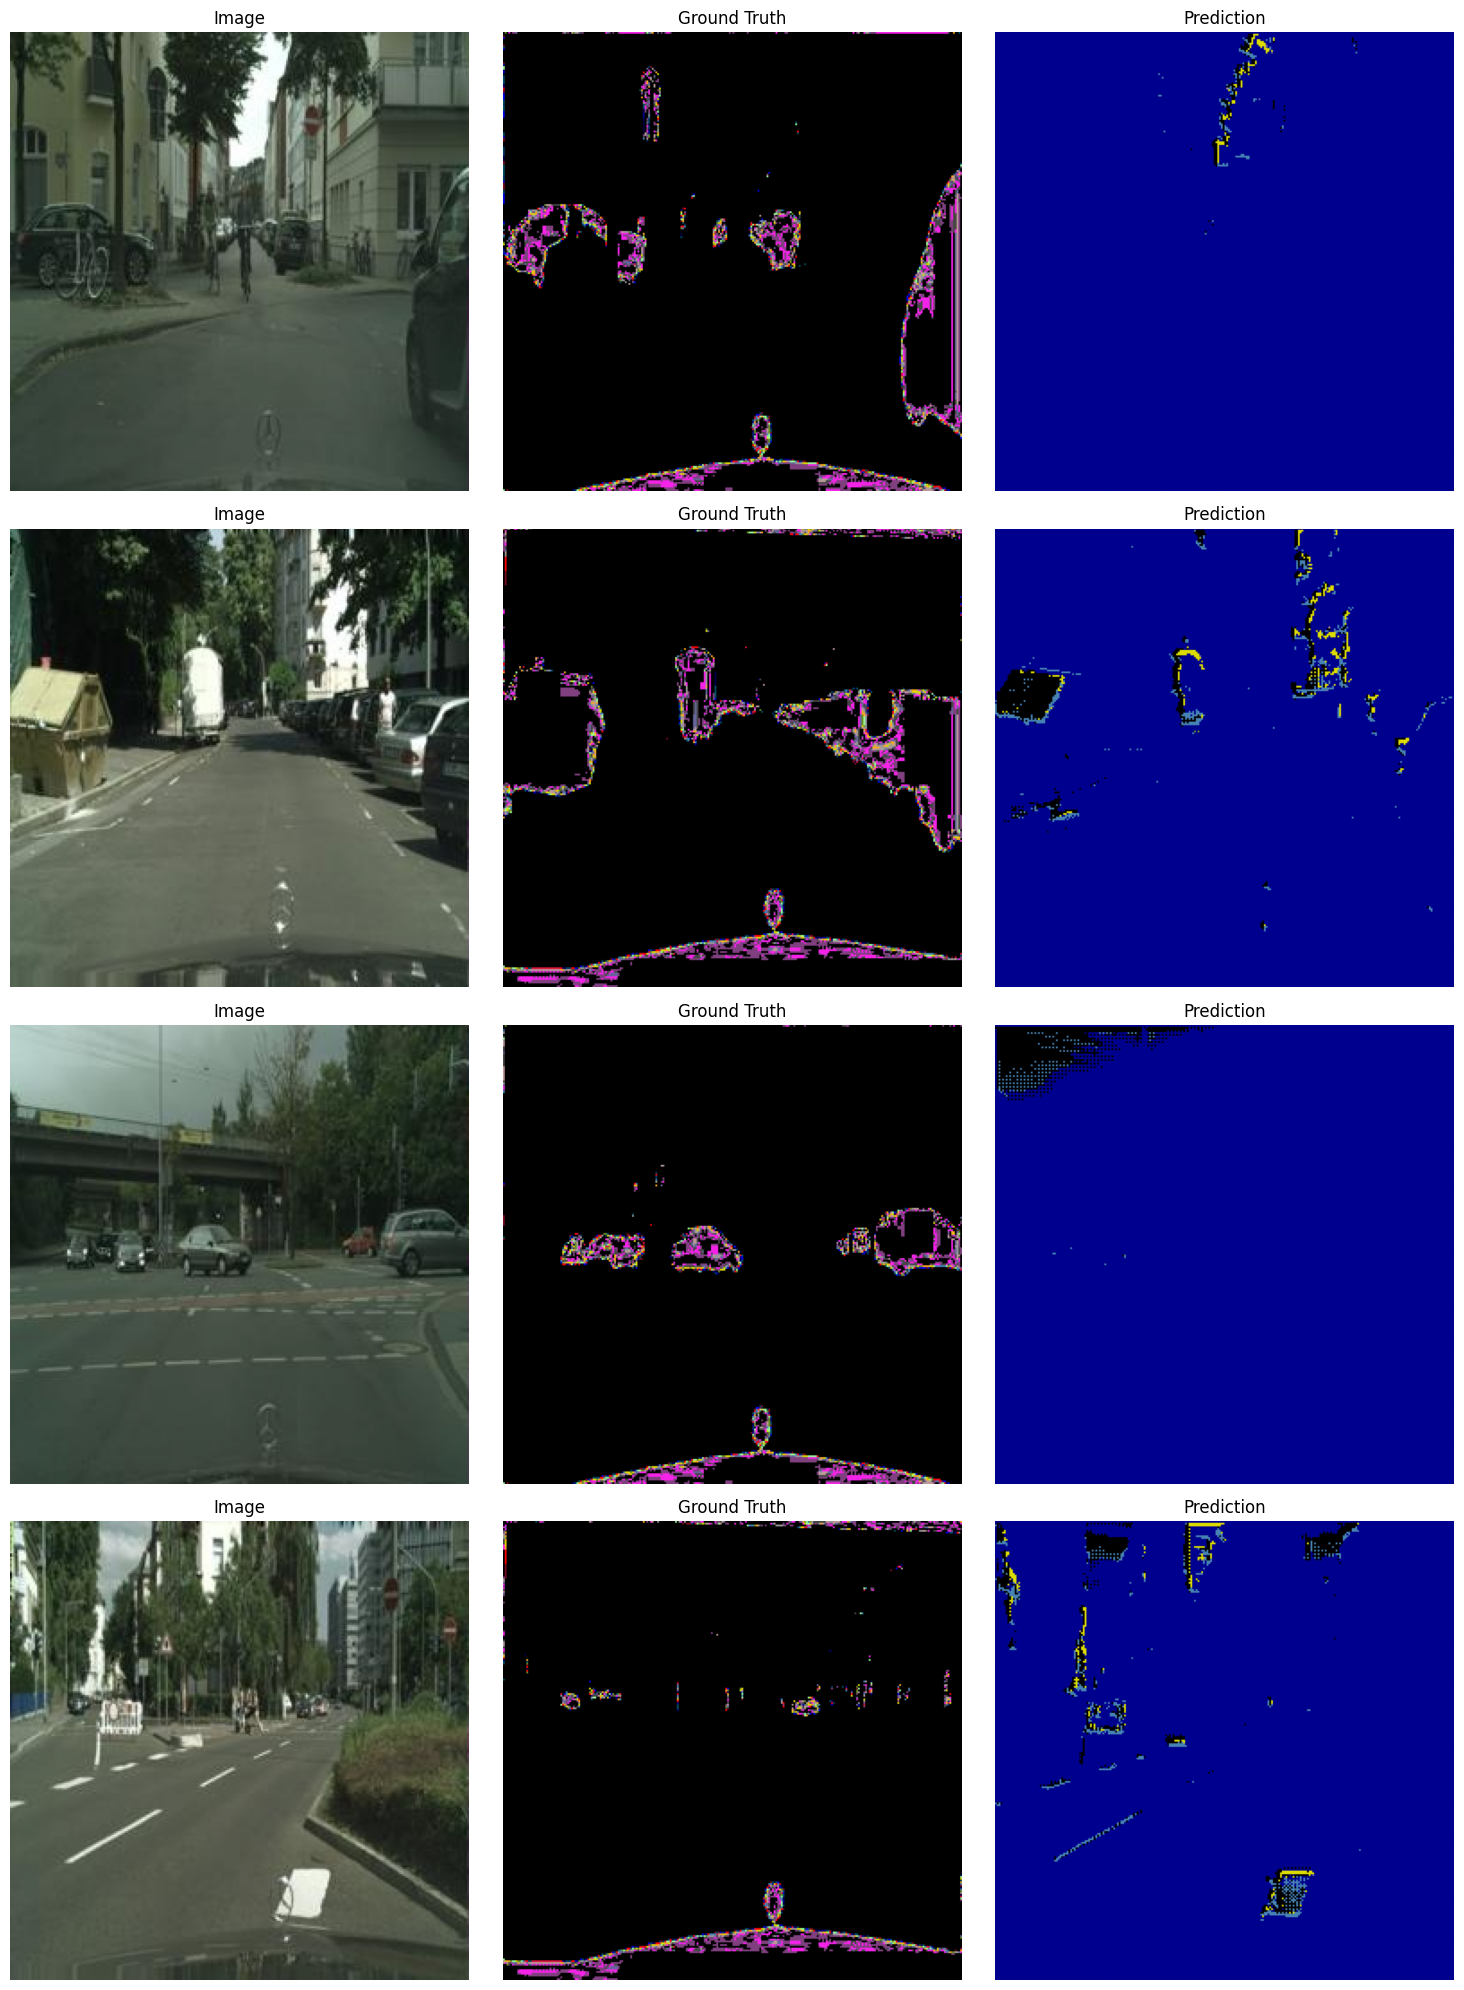

100%|██████████| 32/32 [02:59<00:00,  5.62s/it]



Test Set Metrics:
Loss: 2.9122
IoU: 0.0015
Dice Score: 0.0030
Precision: 0.0500
Recall: 0.0509
F1 Score: 0.0030

Per-class IoU scores:
background: 0.0261
road: 0.0000
sidewalk: 0.0000
building: 0.0000
wall: 0.0003
fence: 0.0000
pole: 0.0000
traffic light: 0.0000
traffic sign: 0.0018
vegetation: 0.0000
terrain: 0.0000
sky: 0.0011
person: 0.0000
rider: 0.0000
car: 0.0011
truck: 0.0000
bus: 0.0000
train: 0.0000
motorcycle: 0.0000
bicycle: 0.0000


In [19]:
# Load the best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = UNet(n_channels=3, n_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load('cityscapes_ce_model.pth'))
loaded_model.eval()

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

# Calculate and print metrics for the test set
criterion = CrossEntropyLoss(ignore_index=255)
test_loss, test_metrics = validate(loaded_model, test_loader, criterion, device, num_classes)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_id, class_name in CITYSCAPES_CLASSES.items():
    if class_id != 255:  # Skip ignore class
        iou_key = f'class_{class_id}_iou'
        if iou_key in test_metrics:
            print(f"{class_name}: {test_metrics[iou_key]:.4f}")

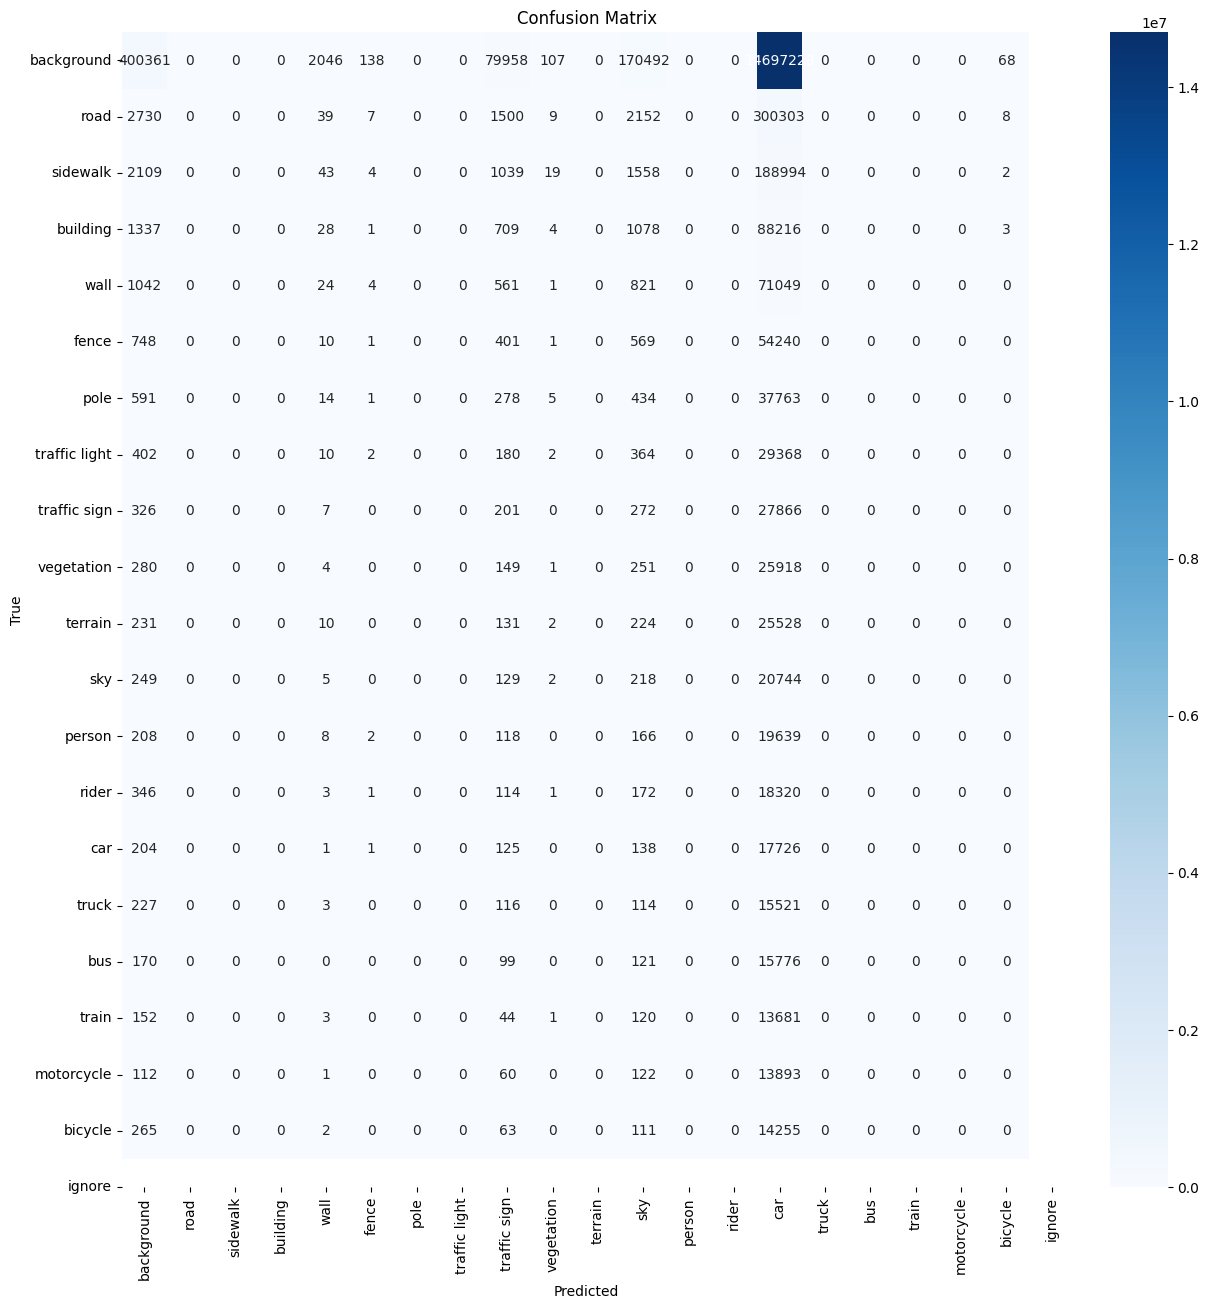

In [20]:
import seaborn as sns

def plot_confusion_matrix(metrics):
    plt.figure(figsize=(15, 15))
    conf_matrix = metrics['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CITYSCAPES_CLASSES.values(), yticklabels=CITYSCAPES_CLASSES.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_metrics)